In [3]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from entsoe2 import fetch_entsoe_data
from n_trim import nordic
from zones import assign_zones
import os

In [4]:
# Path to your solved network
network_path = "base_s_70_elec_.nc"

# Load it
n = pypsa.Network(network_path)

c:\Users\henri\anaconda3\envs\pypsa-eur\Lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning:

Engine 'cfgrib' loading failed:
Cannot find the ecCodes library

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


In [3]:
n = nordic(n, drop_h2_batt=True, extra_buses=['GB4 0'])

In [ ]:
def nice_plot(
    n,
    snap=None,
    zones_path='bidding_zones.geojson',
    # kontrast-innstillinger
    ac_cmap="cividis",          # høy kontrast: "turbo" eller "cividis"
    dc_color="tab:green",     # None -> behold PyPSA default; ellers f.eks. "tab:green"/"cyan"
    bus_color="black",        # nodefarge (svart for kontrast)
    # skaleringsknapper
    bus_base=0.010, bus_scale=0.010,
    line_scale=5.0, link_scale=2.5,
    title="Network",
    alpha = 0.8
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import matplotlib as mpl
    from matplotlib import colors
    try:
        import geopandas as gpd
    except Exception:
        gpd = None

    # snapshot
    if snap is None:
        snap = n.snapshots[0]
    elif isinstance(snap, int):
        snap = n.snapshots[snap]

    # --- bus-størrelse + farge ---
    gen  = n.generators_t.p.loc[snap].groupby(n.generators.bus).sum().reindex(n.buses.index, fill_value=0.0)
    load = (n.loads_t.p.loc[snap].groupby(n.loads.bus).sum().reindex(n.buses.index, fill_value=0.0)
            if not n.loads.empty else pd.Series(0.0, index=n.buses.index))
    net  = (gen - load).abs()
    mx   = float(net.max()) or 1.0
    bus_sizes  = bus_base + bus_scale * (net / mx)
    bus_colors = bus_color

    # --- AC-linjer: tykkelse ∝ s_nom, farge = % loading (0–100) med høy kontrast ---
    line_kwargs = {"line_alpha": alpha}
    cmap = mpl.colormaps.get(ac_cmap)
    norm = colors.Normalize(0, 100)
    if not n.lines.empty:
        s_nom = n.lines.s_nom.replace(0, np.nan)
        mxs   = float(s_nom.max()) if s_nom.notna().any() else 1.0
        line_kwargs["line_widths"] = 1 + line_scale * (s_nom / mxs)

        p0 = n.lines_t.p0.loc[snap].abs().reindex(n.lines.index, fill_value=0.0)
        loading_pct = (100 * (p0 / s_nom)).fillna(0.0).clip(0, 200)
        line_kwargs["line_colors"] = loading_pct.map(lambda v: cmap(norm(v)))
    else:
        line_kwargs["line_widths"] = 1

    # --- DC-linker: tykkelse ∝ p_nom, tydelig grønn (eller standard) ---
    link_kwargs = {}
    if not n.links.empty:
        p_nom = n.links.p_nom.replace(0, np.nan)
        mxp   = float(p_nom.max()) if p_nom.notna().any() else 1.0
        link_kwargs["link_widths"] = 1 + link_scale * (p_nom / mxp)
        link_kwargs["link_alpha"]  = 0.2
        if dc_color is not None:
            link_kwargs["link_colors"] = dc_color  # eksplisitt grønn for kontrast

    # --- plot ---
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    if zones_path and gpd is not None:
        try:
            gdf = gpd.read_file(zones_path)
            gdf.plot(ax=ax, edgecolor="#666666", facecolor="none", linewidth=1.0)   # grå kontur
            gdf.plot(ax=ax, facecolor="#DDDDDD", alpha=0.15, linewidth=0)          # lys fyll
        except Exception:
            pass

    n.plot.map(
        ax=ax,
        bus_sizes=bus_sizes, bus_colors=bus_colors,
        **line_kwargs, **link_kwargs
    )

    if "line_colors" in line_kwargs:
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([]); plt.colorbar(sm, ax=ax, shrink=0.7, label="AC line loading [%]")

    ax.set_title(f"{title} @ {snap}")
    plt.show()


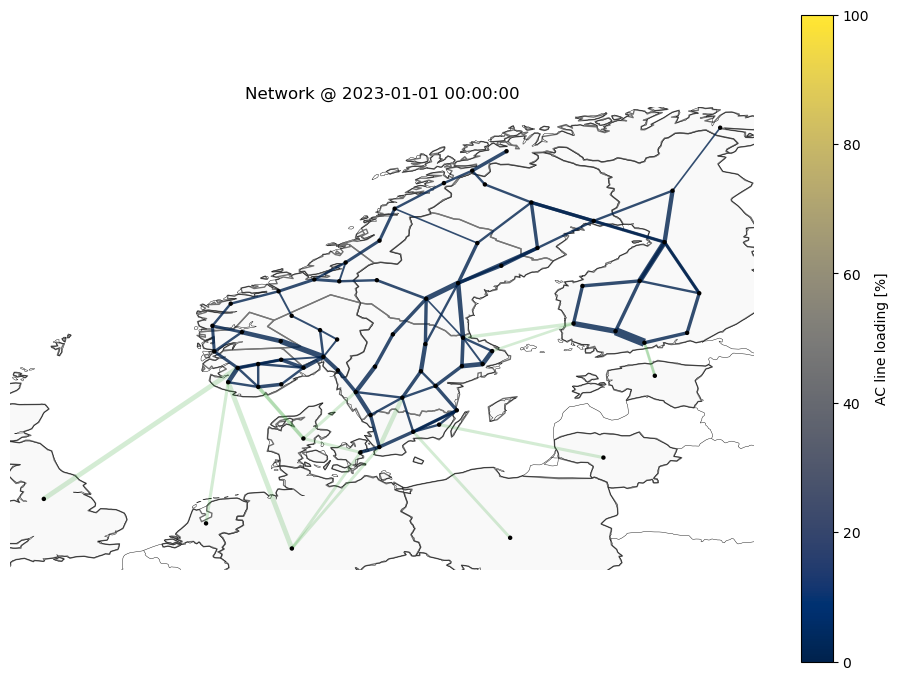

In [5]:
nice_plot(n)

In [6]:
n = assign_zones(n)

In [7]:
n.storage_units["zone"].value_counts()

zone
SE_3     11
NO_2      9
NO_3      9
NO_4      6
FI        5
NO_1      5
SE_2      5
NO_5      4
SE_1      4
SE_4      3
PL        2
DE_LU     1
LT        1
Name: count, dtype: int64

In [10]:
n.generators["zone"].value_counts(dropna=False)

zone
FI       83
SE_3     66
NO_2     39
NO_3     33
SE_4     29
SE_2     27
NO_4     26
NO_1     21
SE_1     15
DE_LU    13
PL       12
GB       11
NO_5     11
DK_1      9
NL        9
LT        9
DK_2      9
EE        7
Name: count, dtype: int64

In [8]:
n.loads["zone"].value_counts()

zone
SE_3     12
FI        9
NO_2      8
NO_4      6
NO_3      6
NO_1      5
SE_2      5
SE_4      4
SE_1      4
NO_5      2
DK_1      1
NL        1
LT        1
PL        1
GB        1
EE        1
DK_2      1
DE_LU     1
Name: count, dtype: int64

In [9]:
loads_df, gens_df, ac_flows_df, dc_flows_df = fetch_entsoe_data(start_date="2023-01-01", timezone="Europe/Oslo")

In [10]:
dc_flows_df

DC interconnector,DE_LU<->DK_2,DE_LU<->NO_2,DE_LU<->SE_4,DK_1<->NL,DK_1<->NO_2,EE<->FI,FI<->SE_3,GB<->NO_2,LT<->SE_4,NL<->NO_2,PL<->SE_4
Snapshot,,,,,,,,,,,
2023-01-01 00:00:00,273.4800,1272.9050,468.79,-500.0525,1610.67,-812.750,187.65,-627.87,-525.83,649.0900,197.88
2023-01-01 01:00:00,164.1175,1288.9900,506.32,-574.7625,1611.32,-1005.550,176.82,-178.78,-326.18,649.0900,6.69
2023-01-01 02:00:00,171.0300,1298.0250,506.32,-619.3425,1611.83,-1013.450,187.49,270.90,-285.48,649.0900,0.00
2023-01-01 03:00:00,306.4950,1298.7775,506.46,-604.4025,1611.77,-1015.300,187.70,713.15,-521.35,649.0900,0.00
2023-01-01 04:00:00,157.1400,1308.3600,505.98,-579.5525,1611.75,-1006.700,187.54,1002.64,-406.59,649.0900,0.00
2023-01-01 05:00:00,293.2100,1319.4875,506.13,-670.0225,1611.50,-1000.650,106.78,1013.98,-662.71,649.0900,0.00
2023-01-01 06:00:00,234.9800,1373.9975,505.98,-692.1275,1611.65,-1012.200,181.57,1013.99,-611.06,649.0900,0.00
2023-01-01 07:00:00,245.1050,1393.8425,505.85,-571.3225,1611.58,-794.985,183.81,1013.99,-472.82,649.0900,0.00
2023-01-01 08:00:00,402.4475,1375.0800,506.34,-679.6825,1612.05,-705.295,183.49,993.83,-462.60,649.0900,0.00


In [12]:
n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_shut_down,p_nom_opt,voltage,underground,under_construction,tags,geometry,dc,underwater_fraction,project_status
Link,,,,,,,,,,,,,,,,,,,,,
relation/13295785-515-DC,NO1 5,GB3 0,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,0.0,515.0,1.0,0.0,relation/13295785,LINESTRING (-1.5404269162550226 55.14647596191...,1.0,0.983350,
relation/16213216-525-DC,DE0 0,NO1 19,,DC,1.0,True,0,inf,1400.0,0.0,...,1.0,0.0,525.0,1.0,0.0,relation/16213216,LINESTRING (6.7544309946114405 58.669060406684...,1.0,0.802530,
relation/2505320-400-DC,DK1 0,DE0 0,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,400.0,1.0,0.0,relation/2505320,LINESTRING (12.0074143643741 55.45030397887522...,1.0,0.281105,
relation/3391931-350-DC,DK0 0,NO1 12,,DC,1.0,True,0,inf,940.0,0.0,...,1.0,0.0,350.0,1.0,0.0,relation/3391931,LINESTRING (7.900400664968465 58.2597498120886...,1.0,0.505184,
relation/3391954-500-DC,FI1 0,SE1 18,,DC,1.0,True,0,inf,800.0,0.0,...,1.0,0.0,500.0,1.0,0.0,relation/3391954,LINESTRING (17.063499290470876 60.425539004588...,1.0,0.658712,
relation/3392010-450-DC,PL0 0,SE1 10,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/3392010,LINESTRING (14.84028235523815 56.1530147407003...,1.0,0.940780,
relation/3918230-450-DC,DE0 0,SE1 2,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/3918230,LINESTRING (10.80243095002194 53.8961375941516...,1.0,0.927793,
relation/5487095-400-DC,DK0 0,DK1 0,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,0.0,400.0,1.0,0.0,relation/5487095,LINESTRING (10.505724427906852 55.365970143543...,1.0,0.560249,
relation/6886400-450-DC,EE2 0,FI1 5,,DC,1.0,True,0,inf,650.0,0.0,...,1.0,0.0,450.0,1.0,0.0,relation/6886400,LINESTRING (25.367309680105414 60.377636227284...,1.0,0.843705,


In [11]:
import numpy as np
import pandas as pd

# --- 0) reindekser tidsserier (kjør ETTER at du ev. har lagt til virtuelle enheter)
n.generators_t.p_set    = n.generators_t.p_set.reindex(n.snapshots, columns=n.generators.index, fill_value=0.0)
n.storage_units_t.p_set = n.storage_units_t.p_set.reindex(n.snapshots, columns=n.storage_units.index, fill_value=0.0)
n.loads_t.p_set         = n.loads_t.p_set.reindex(n.snapshots, columns=n.loads.index, fill_value=0.0)

# --- 1) sørg for 'zone' på alle komponenter (fra bus hvis mangler)
for comp in (n.generators, n.storage_units, n.loads):
    if "zone" not in comp.columns:
        comp["zone"] = comp.bus.map(n.buses.zone)
    else:
        comp["zone"] = comp["zone"].fillna(comp.bus.map(n.buses.zone))

# --- 2) carrier -> ENTSO-E Technology (tilpass ved behov)
tech_map = {
    "ccgt":"Fossil Gas","ocgt":"Fossil Gas","biomass":"Biomass",
    "coal":"Fossil Hard coal","lignite":"Fossil Brown coal/Lignite","oil":"Fossil Oil",
    "nuclear":"Nuclear","onwind":"Wind Onshore",
    "offwind-ac":"Wind Offshore","offwind-dc":"Wind Offshore","offwind-float":"Wind Offshore",
    "solar":"Solar","solar-hsat":"Solar","ror":"Hydro Run-of-river and poundage",
    "phs":"Hydro Pumped Storage","hydro":"Hydro Water Reservoir",
    "waste":"Waste","peat":"Fossil Peat","other":"Other","other renewable":"Other renewable",
}

def distribute_generation(comp, out_ts, col_nom="p_nom"):
    """Fordel gens_df[Zone,Technology] proporsjonalt på enheter etter p_nom, kaps maksimalt ved sum p_nom."""
    tech = comp.carrier.astype(str).str.lower().map(tech_map).fillna("Other")
    groups = comp.groupby([comp["zone"].astype(str).rename("Zone"),
                           tech.rename("Technology")]).groups

    for (Z, T), idx in groups.items():
        idx = pd.Index(idx)
        if len(idx) == 0 or (Z, T) not in gens_df.columns:
            continue
        s    = gens_df[(Z, T)].reindex(n.snapshots).fillna(0.0).to_numpy()     # (T,)
        caps = comp.loc[idx, col_nom].astype(float).to_numpy()                  # (N,)
        S    = caps.sum()
        if S <= 0: 
            continue
        out_ts.loc[:, idx] = np.minimum(s, S)[:, None] * (caps / S)[None, :]    # cap & fordel etter p_nom

def distribute_loads_equal(loads_df):
    """Fordel last likt på alle laster i samme prissone."""
    if loads_df is None or loads_df.empty:
        return
    for Z, idx in n.loads.groupby("zone").groups.items():
        idx = pd.Index(idx)
        if len(idx) == 0 or Z not in loads_df.columns:
            continue
        s = loads_df[Z].reindex(n.snapshots).fillna(0.0).to_numpy()
        n.loads_t.p_set.loc[:, idx] = s[:, None] / len(idx)

# --- 3) kjør fordeling
distribute_generation(n.generators,    n.generators_t.p_set)
distribute_generation(n.storage_units, n.storage_units_t.p_set)  # ta med storage hvis ønsket
distribute_loads_equal(loads_df)

# --- 4) kjappe sanity-checker
gm, gp = n.generators_t.p_set.max(0).align(n.generators.p_nom, 'inner')
sm, sp = n.storage_units_t.p_set.max(0).align(n.storage_units.p_nom, 'inner')
assert (gm.to_numpy() <= gp.to_numpy() + 1e-9).all()
assert (sm.to_numpy() <= sp.to_numpy() + 1e-9).all()

# --- 5) vis totalsummer per snapshot
gen_total  = n.generators_t.p_set.sum(1) + n.storage_units_t.p_set.clip(lower=0).sum(1)
load_total = n.loads_t.p_set.sum(1)      + (-n.storage_units_t.p_set.clip(upper=0)).sum(1)
print("Produksjon (MW) – første rader:\n", gen_total.head())
print("\nLast (MW) – første rader:\n", load_total.head())


Produksjon (MW) – første rader:
 snapshot
2023-01-01 00:00:00    34230.42959
2023-01-01 01:00:00    33435.42959
2023-01-01 02:00:00    32516.42959
2023-01-01 03:00:00    31993.42959
2023-01-01 04:00:00    31656.42959
dtype: float64

Last (MW) – første rader:
 snapshot
2023-01-01 00:00:00    140586.776779
2023-01-01 01:00:00    137223.275078
2023-01-01 02:00:00    135206.844955
2023-01-01 03:00:00    134069.512527
2023-01-01 04:00:00    132036.807800
dtype: float64


In [12]:
import numpy as np
import pandas as pd

def validate_distribution(n, gens_df, loads_df=None, tol=1e-5):
    ok = True

    # --- 0) grunnleggende justering
    n.generators_t.p_set = n.generators_t.p_set.reindex(n.snapshots, columns=n.generators.index, fill_value=0.0)
    n.storage_units_t.p_set = n.storage_units_t.p_set.reindex(n.snapshots, columns=n.storage_units.index, fill_value=0.0)
    n.loads_t.p_set = n.loads_t.p_set.reindex(n.snapshots, columns=n.loads.index, fill_value=0.0)

    # --- 1) p_set ≤ p_nom per enhet
    gm, gp = n.generators_t.p_set.max(0).align(n.generators.p_nom, 'inner')
    sm, sp = n.storage_units_t.p_set.max(0).align(n.storage_units.p_nom, 'inner')
    if not (gm.to_numpy() <= gp.to_numpy() + 1e-9).all():
        ok = False; print("FEIL: Noen generatorer har p_set > p_nom")
    if not (sm.to_numpy() <= sp.to_numpy() + 1e-9).all():
        ok = False; print("FEIL: Noen storage-units har p_set > p_nom")

    # --- 2) forbered (Zone,Technology)
    tech_map = {
        "ccgt":"Fossil Gas","ocgt":"Fossil Gas","biomass":"Biomass",
        "coal":"Fossil Hard coal","lignite":"Fossil Brown coal/Lignite","oil":"Fossil Oil",
        "nuclear":"Nuclear","onwind":"Wind Onshore",
        "offwind-ac":"Wind Offshore","offwind-dc":"Wind Offshore","offwind-float":"Wind Offshore",
        "solar":"Solar","solar-hsat":"Solar","ror":"Hydro Run-of-river and poundage",
        "phs":"Hydro Pumped Storage","hydro":"Hydro Water Reservoir",
        "waste":"Waste","peat":"Fossil Peat","other":"Other","other renewable":"Other renewable",
    }

    gZ = n.generators["zone"].astype(str)
    sZ = n.storage_units["zone"].astype(str)
    gT = n.generators.carrier.astype(str).str.lower().map(tech_map).fillna("Other")
    sT = n.storage_units.carrier.astype(str).str.lower().map(tech_map).fillna("Other")

    cap_g = n.generators.groupby([gZ, gT])["p_nom"].sum()
    cap_s = n.storage_units.groupby([sZ, sT])["p_nom"].sum()
    cap_sum = cap_g.add(cap_s, fill_value=0.0)  # kapasitet per (Z,T)

    # mål (reindex snapshots)
    targets = gens_df.reindex(n.snapshots).fillna(0.0)
    if not (isinstance(targets.columns, pd.MultiIndex) and list(targets.columns.names)==["Zone","Technology"]):
        raise ValueError("gens_df-kolonner må være MultiIndex ('Zone','Technology').")

    # allokert (Z,T): summer p_set over enheter i samme (Z,T)
    alloc_g = n.generators_t.p_set.groupby([gZ, gT], axis=1).sum()
    alloc_s = n.storage_units_t.p_set.groupby([sZ, sT], axis=1).sum()
    alloc = alloc_g.add(alloc_s, fill_value=0.0)  # DataFrame (snapshots x (Z,T))

    # align all three
    cols = sorted(set(targets.columns) | set(alloc.columns))
    targets = targets.reindex(columns=cols, fill_value=0.0)
    alloc   = alloc.reindex(columns=cols, fill_value=0.0)

    # forventet = min(mål, kapasitet) per (Z,T) for hver snapshot
    cap_vec = pd.Series({c: cap_sum.get(c, 0.0) for c in cols})
    exp = pd.DataFrame({c: np.minimum(targets[c].to_numpy(), cap_vec[c]) for c in cols}, index=n.snapshots)

    # avvik
    err = (alloc - exp).abs().max(axis=0)
    bad_cols = err[err > tol].sort_values(ascending=False)
    if len(bad_cols):
        ok = False
        print("FEIL (Z,T) allokering avviker fra min(mål, kapasitet) (topp 10):")
        for (z,t), e in bad_cols.head(10).items():
            print(f"  {(z,t)} max|diff|={e:.3f} MW  (kap={cap_vec[(z,t)]:.1f})")

    # rapporter (Z,T) med mål>0 men kap=0
    missing_cap = [(z,t,targets[(z,t)].max()) for (z,t) in targets.columns if targets[(z,t)].max()>0 and cap_vec[(z,t)]<=0]
    if missing_cap:
        print("ADVARSEL: Mål uten kapasitet (Z,T) (topp 10):", missing_cap[:10])

    # --- 3) valider laster per sone
    if loads_df is not None:
        loads_target = loads_df.reindex(n.snapshots).fillna(0.0)
        by_zone_load = n.loads_t.p_set.groupby(n.loads["zone"].astype(str), axis=1).sum()
        # align soner
        zcols = sorted(set(loads_target.columns) | set(by_zone_load.columns))
        loads_target = loads_target.reindex(columns=zcols, fill_value=0.0)
        by_zone_load = by_zone_load.reindex(columns=zcols, fill_value=0.0)
        load_err = (by_zone_load - loads_target).abs().max(axis=0)
        bad_z = load_err[load_err > tol]
        if len(bad_z):
            ok = False
            print("FEIL last per sone (topp 10):")
            for z,e in bad_z.sort_values(ascending=False).head(10).items():
                print(f"  {z}: max|diff|={e:.3f} MW")
        else:
            print("OK: Last per sone matcher loads_df.")

    # --- 4) totalsjekk (energi-balanse uten DC)
    gen_tot  = n.generators_t.p_set.sum(1) + n.storage_units_t.p_set.clip(lower=0).sum(1)
    load_tot = n.loads_t.p_set.sum(1)      + (-n.storage_units_t.p_set.clip(upper=0)).sum(1)
    print("Totalsjekk (første 3 rader):")
    print(pd.DataFrame({"Gen":gen_tot, "Load":load_tot, "Gen-Load":gen_tot-load_tot}).head(3))

    if ok:
        print("VALIDERING OK ✔")
    else:
        print("VALIDERING: FEIL funnet ✖")
    return ok

# kall:
validate_distribution(n, gens_df, loads_df)


ADVARSEL: Mål uten kapasitet (Z,T) (topp 10): [('DK_2', 'Fossil Oil', 31.0), ('DK_2', 'Waste', 68.0), ('FI', 'Fossil Peat', 333.0), ('FI', 'Other', 100.0), ('FI', 'Other renewable', 2.0), ('FI', 'Waste', 25.0), ('NO_1', 'Waste', 10.0), ('NO_2', 'Waste', 13.0), ('NO_3', 'Hydro Run-of-river and poundage', 199.0), ('NO_3', 'Other renewable', 23.0)]
FEIL last per sone (topp 10):
  DE_LU: max|diff|=57499.915 MW
  GB: max|diff|=43012.672 MW
  PL: max|diff|=20160.746 MW
  NL: max|diff|=14043.905 MW
  DK_1: max|diff|=2168.371 MW
  LT: max|diff|=1367.556 MW
  EE: max|diff|=1082.943 MW
Totalsjekk (første 3 rader):
                             Gen           Load       Gen-Load
snapshot                                                      
2023-01-01 00:00:00  34230.42959  140586.776779 -106356.347189
2023-01-01 01:00:00  33435.42959  137223.275078 -103787.845488
2023-01-01 02:00:00  32516.42959  135206.844955 -102690.415366
VALIDERING: FEIL funnet ✖


C:\Users\henri\AppData\Local\Temp\ipykernel_10052\478265124.py:46: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\henri\AppData\Local\Temp\ipykernel_10052\478265124.py:47: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\henri\AppData\Local\Temp\ipykernel_10052\478265124.py:76: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



False

In [16]:
n.generators.loc[(n.generators.zone == "NO_3") & (n.generators.index.str.endswith('ror'))]

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,zone
Generator,,,,,,,,,,,,,,,,,,,,,


In [17]:
print("gens_df soner:", sorted(set(gens_df.columns.get_level_values("Zone"))))


gens_df soner: ['DK_2', 'FI', 'NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5', 'SE_1', 'SE_2', 'SE_3', 'SE_4']


In [18]:
import numpy as np

# align
n.links_t.p_set = n.links_t.p_set.reindex(n.snapshots, columns=n.links.index, fill_value=0.0)

# DC subset (adjust if needed)
dc = (n.links.index[n.links.carrier.astype(str).str.contains("dc", case=False, na=False)]
      if "carrier" in n.links.columns else n.links.index)

# zones at terminals
z = n.buses["zone"].astype(str)
L = n.links.loc[dc, ["bus0","bus1","p_nom"]].assign(z0=lambda d: d.bus0.map(z),
                                                    z1=lambda d: d.bus1.map(z))

# group by unordered zone pair
pairs = L.assign(pair=lambda d: list(map(frozenset, zip(d.z0, d.z1)))).groupby("pair")

for pair, sub in pairs:
    A, B = sorted(tuple(pair))
    colAB, colBA = f"{A}<->{B}", f"{B}<->{A}"
    if colAB in dc_flows_df.columns:
        s = dc_flows_df[colAB].reindex(n.snapshots).fillna(0.0).to_numpy()   # A→B request
    elif colBA in dc_flows_df.columns:
        s = -dc_flows_df[colBA].reindex(n.snapshots).fillna(0.0).to_numpy()  # flip to A→B
    else:
        continue

    # indices per orientation
    fwd = sub.index[(sub.z0 == A) & (sub.z1 == B)]
    rev = sub.index[(sub.z0 == B) & (sub.z1 == A)]

    pf = n.links.loc[fwd, "p_nom"].astype(float).to_numpy() if len(fwd) else np.array([])
    pr = n.links.loc[rev, "p_nom"].astype(float).to_numpy() if len(rev) else np.array([])
    capf, capr = (pf.sum() if pf.size else 0.0), (pr.sum() if pr.size else 0.0)

    # split the request across whatever capacity exists (handles single-orientation corridors)
    pos = np.maximum(s, 0.0)   # A→B
    neg = np.maximum(-s, 0.0)  # B→A

    # positive request: first fill fwd (+), remainder on rev (−)
    x_pos = np.minimum(pos, capf)
    y_pos = np.minimum(pos - x_pos, capr)

    # negative request: first fill rev (+), remainder on fwd (−)
    x_neg = np.minimum(neg, capr)
    y_neg = np.minimum(neg - x_neg, capf)

    fwd_set = (+x_pos) - (y_neg)     # fwd links get + for A→B, − for B→A remainder
    rev_set = (+x_neg) - (y_pos)     # rev links get + for B→A, − for A→B remainder

    if capf and len(fwd):
        n.links_t.p_set.loc[:, fwd] = fwd_set[:, None] * (pf / capf)[None, :]
    if capr and len(rev):
        n.links_t.p_set.loc[:, rev] = rev_set[:, None] * (pr / capr)[None, :]

# sanity
mx, pn = np.abs(n.links_t.p_set).max(axis=0).align(n.links.p_nom, 'inner')
assert (mx.to_numpy() <= pn.to_numpy() + 1e-9).all()


In [20]:
n.links_t.p_set

Link,relation/13295785-515-DC,relation/16213216-525-DC,relation/2505320-400-DC,relation/3391931-350-DC,relation/3391954-500-DC,relation/3392010-450-DC,relation/3918230-450-DC,relation/5487095-400-DC,relation/6886400-450-DC,relation/8184629-300-DC,relation/8184630-150-DC,relation/8184631-400-DC,relation/8184632-500-DC,relation/8184633-300-DC,relation/8185455-300-DC,relation/9965201-450-DC,TYNDP2020_38
snapshot,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,627.87,1272.9050,-273.4800,923.188902,187.65,197.88,468.79,0.0,-528.28750,0.0,-284.46250,0.0,687.481098,0.0,-525.83,649.0900,0.0
2023-01-01 01:00:00,178.78,1288.9900,-164.1175,923.561463,176.82,6.69,506.32,0.0,-650.00000,0.0,-350.00000,0.0,687.758537,0.0,-326.18,649.0900,0.0
2023-01-01 02:00:00,-270.90,1298.0250,-171.0300,923.853780,187.49,0.00,506.32,0.0,-650.00000,0.0,-350.00000,0.0,687.976220,0.0,-285.48,649.0900,0.0
2023-01-01 03:00:00,-713.15,1298.7775,-306.4950,923.819390,187.70,0.00,506.46,0.0,-650.00000,0.0,-350.00000,0.0,687.950610,0.0,-521.35,649.0900,0.0
2023-01-01 04:00:00,-1002.64,1308.3600,-157.1400,923.807927,187.54,0.00,505.98,0.0,-650.00000,0.0,-350.00000,0.0,687.942073,0.0,-406.59,649.0900,0.0
2023-01-01 05:00:00,-1013.98,1319.4875,-293.2100,923.664634,106.78,0.00,506.13,0.0,-650.00000,0.0,-350.00000,0.0,687.835366,0.0,-662.71,649.0900,0.0
2023-01-01 06:00:00,-1013.99,1373.9975,-234.9800,923.750610,181.57,0.00,505.98,0.0,-650.00000,0.0,-350.00000,0.0,687.899390,0.0,-611.06,649.0900,0.0
2023-01-01 07:00:00,-1013.99,1393.8425,-245.1050,923.710488,183.81,0.00,505.85,0.0,-516.74025,0.0,-278.24475,0.0,687.869512,0.0,-472.82,649.0900,0.0
2023-01-01 08:00:00,-993.83,1375.0800,-402.4475,923.979878,183.49,0.00,506.34,0.0,-458.44175,0.0,-246.85325,0.0,688.070122,0.0,-462.60,649.0900,0.0


ValueError: operands could not be broadcast together with shapes (429,) (447,) 

Added virtual generators: [('DK_2', 'Fossil Oil', 'oil', 31.0), ('DK_2', 'Waste', 'waste', 68.0), ('FI', 'Fossil Peat', 'peat', 333.0), ('FI', 'Other', 'other', 100.0), ('FI', 'Other renewable', 'other renewable', 2.0), ('FI', 'Waste', 'waste', 25.0), ('NO_1', 'Waste', 'waste', 10.0), ('NO_2', 'Waste', 'waste', 13.0)] ...


In [21]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For generators
gen_per_zone = n.generators.groupby('zone')['carrier'].unique().apply(list).sort_index()
print("Generators types per bidding zone:")
print(gen_per_zone)

# For storage units
su_per_zone = n.storage_units.groupby('zone')['carrier'].unique().apply(list).sort_index()
print("\nStorage units types per bidding zone:")
print(su_per_zone)

Generators types per bidding zone:
zone
DE_LU    [CCGT, OCGT, biomass, coal, lignite, oil, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc, ror]
DK_1                              [CCGT, biomass, coal, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc]
DK_2                              [CCGT, biomass, coal, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc]
EE                                               [CCGT, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc]
FI             [CCGT, biomass, coal, nuclear, oil, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc, ror]
GB                  [CCGT, biomass, coal, nuclear, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc, ror]
LT                                 [CCGT, biomass, onwind, offwind-float, offwind-ac, solar, solar-hsat, offwind-dc, ror]
NL                                [CCGT, biomass, coal, onwind, offwind-float, offwind-ac, solar, solar-hs

KeyError: 'Column not found: bus_id'

In [24]:
# 1) find AC islands
n.determine_network_topology()  # adds buses.sub_network

# 2) map each generator to its island
g = n.generators.copy()
g["subnet"] = g.bus.map(n.buses.sub_network)

# 3) prefer dispatchable carriers
non_dispatchable = {"onwind","offwind-ac","offwind-dc","offwind-float","solar","ror"}
g["is_dispatchable"] = ~g.carrier.astype(str).str.lower().isin(non_dispatchable)

# 4) choose one per island: max p_nom among dispatchable; if none, fall back to max p_nom overall
pick = (
    g.sort_values(["subnet","is_dispatchable","p_nom"], ascending=[True, False, False])
     .groupby("subnet")
     .head(1)
     .index
)

# 5) set control flags
if "control" not in n.generators.columns:
    n.generators["control"] = ""
n.generators["control"] = n.generators["control"].where(~n.generators.index.isin(n.generators.index), "")  # clear all
n.generators.loc[pick, "control"] = "Slack"

print(f"Slack generators ({len(pick)}):")
print(n.generators.loc[pick, ["bus","carrier","p_nom","control"]])


Slack generators (8):
                   bus  carrier         p_nom control
Generator                                            
DE0 0 CCGT       DE0 0     CCGT  27588.683094   Slack
DK0 0 coal       DK0 0     coal   1817.885609   Slack
SE1 15 nuclear  SE1 15  nuclear   3956.000000   Slack
EE2 0 CCGT       EE2 0     CCGT    216.000000   Slack
GB3 0 CCGT       GB3 0     CCGT  30600.400000   Slack
LT0 0 CCGT       LT0 0     CCGT   1148.000000   Slack
NL0 0 CCGT       NL0 0     CCGT  10448.000000   Slack
PL0 0 coal       PL0 0     coal  13595.179594   Slack


In [28]:
# normalize zone labels (handles NO1 vs NO_1 etc.)
def norm(z): 
    z = str(z).upper().replace("-", "_")
    return {"NO1":"NO_1", "NO3":"NO_3"}.get(z, z)

zbus = n.buses["zone"].map(norm).astype(str)

# --- AC lines NO_1 <-> NO_3
z0 = n.lines["bus0"].map(zbus)
z1 = n.lines["bus1"].map(zbus)
mask_lines = ((z0=="NO_5") & (z1=="NO_1"))
lines_NO1_NO3 = n.lines.index[mask_lines]

print("AC lines NO_1<->NO_5:", list(lines_NO1_NO3))
# Optional: see basic info
print(n.lines.loc[lines_NO1_NO3, ["bus0","bus1","s_nom","length"]])


AC lines NO_1<->NO_5: ['52']
       bus0    bus1        s_nom     length
Line                                       
52    NO1 2  NO1 20  7641.461753  132.60415


In [26]:
n.lines_t.p1['52']

snapshot
2023-01-01 00:00:00    204.513359
2023-01-01 01:00:00    178.005968
2023-01-01 02:00:00    362.637832
2023-01-01 03:00:00    362.926863
2023-01-01 04:00:00    302.456569
2023-01-01 05:00:00    411.006998
2023-01-01 06:00:00    349.446256
2023-01-01 07:00:00    283.544617
2023-01-01 08:00:00    269.301168
2023-01-01 09:00:00    239.549760
2023-01-01 10:00:00    277.019477
2023-01-01 11:00:00    229.900288
2023-01-01 12:00:00    133.537457
2023-01-01 13:00:00     66.479585
2023-01-01 14:00:00    287.888316
2023-01-01 15:00:00     92.661325
2023-01-01 16:00:00   -158.678094
2023-01-01 17:00:00   -265.462139
2023-01-01 18:00:00   -242.545376
2023-01-01 19:00:00   -275.005420
2023-01-01 20:00:00   -332.582839
2023-01-01 21:00:00   -254.401513
2023-01-01 22:00:00      5.702336
2023-01-01 23:00:00      3.044986
Name: 52, dtype: float64

In [73]:
# list all generators in DK_2
g = n.generators
if "zone" not in g.columns:
    g["zone"] = g.bus.map(n.buses["zone"])

dk2 = g[g["zone"].astype(str) == "DK_2"]

print(f"# generators in DK_2: {len(dk2)}")
print(dk2[["bus","carrier","p_nom"]].sort_values("p_nom", ascending=False))

# optional: capacity by technology
print("\nCapacity by technology (MW):")
print(dk2.groupby(dk2["carrier"].astype(str))["p_nom"].sum().sort_values(ascending=False))


# generators in DK_2: 9
                         bus        carrier        p_nom
Generator                                               
DK1 0 coal             DK1 0           coal  1266.000000
DK1 0 0 offwind-ac     DK1 0     offwind-ac  1050.000000
DK1 0 CCGT             DK1 0           CCGT  1038.000000
DK1 0 0 onwind         DK1 0         onwind   819.238814
DK1 0 0 solar          DK1 0          solar   539.000000
DK1 0 biomass          DK1 0        biomass   311.000000
DK1 0 0 offwind-float  DK1 0  offwind-float     0.000000
DK1 0 0 solar-hsat     DK1 0     solar-hsat     0.000000
DK1 0 0 offwind-dc     DK1 0     offwind-dc     0.000000

Capacity by technology (MW):
carrier
coal             1266.000000
offwind-ac       1050.000000
CCGT             1038.000000
onwind            819.238814
solar             539.000000
biomass           311.000000
offwind-dc          0.000000
offwind-float       0.000000
solar-hsat          0.000000
Name: p_nom, dtype: float64


In [29]:
import pandas as pd

g = n.generators.copy()
b = n.buses

# case-insensitive control flag, if present
ctrl = g["control"].astype(str).str.lower() if "control" in g.columns else pd.Series("", index=g.index)
is_slack_control = ctrl.eq("slack")

# buses flagged as slack
bus_is_slack = b["slack"].fillna(False) if "slack" in b.columns else pd.Series(False, index=b.index)
is_on_slack_bus = g["bus"].isin(b.index[bus_is_slack])

slack_gens = g[is_slack_control | is_on_slack_bus]

print(f"# slack generators: {len(slack_gens)}")
cols = ["bus","carrier","p_nom"] + ([ "control"] if "control" in g.columns else [])
print(slack_gens[cols])


# slack generators: 8
                   bus  carrier         p_nom control
Generator                                            
DE0 0 CCGT       DE0 0     CCGT  27588.683094   Slack
DK0 0 coal       DK0 0     coal   1817.885609   Slack
EE2 0 CCGT       EE2 0     CCGT    216.000000   Slack
GB3 0 CCGT       GB3 0     CCGT  30600.400000   Slack
LT0 0 CCGT       LT0 0     CCGT   1148.000000   Slack
NL0 0 CCGT       NL0 0     CCGT  10448.000000   Slack
PL0 0 coal       PL0 0     coal  13595.179594   Slack
SE1 15 nuclear  SE1 15  nuclear   3956.000000   Slack


In [30]:
print(n.generators_t.p[slack_gens.index])          # full time series for slack gens
print(n.generators_t.p[slack_gens.index].sum(1))   # their total per snapshot


Generator            DE0 0 CCGT  DK0 0 coal  EE2 0 CCGT  GB3 0 CCGT  \
snapshot                                                              
2023-01-01 00:00:00   2015.1750     1610.67    -812.750     -627.87   
2023-01-01 01:00:00   1959.4275     1611.32   -1000.000     -178.78   
2023-01-01 02:00:00   1975.3750     1611.83   -1000.000      270.90   
2023-01-01 03:00:00   2111.7325     1611.77   -1000.000      713.15   
2023-01-01 04:00:00   1971.4800     1611.75   -1000.000     1002.64   
2023-01-01 05:00:00   2118.8275     1611.50   -1000.000     1013.98   
2023-01-01 06:00:00   2114.9575     1611.65   -1000.000     1013.99   
2023-01-01 07:00:00   2144.7975     1611.58    -794.985     1013.99   
2023-01-01 08:00:00   2283.8675     1612.05    -705.295      993.83   
2023-01-01 09:00:00   2187.6550     1612.06    -679.770      561.95   
2023-01-01 10:00:00   2295.3050     1612.37    -513.340      112.93   
2023-01-01 11:00:00   2250.5950     1612.76    -574.335     -336.18   
2023-0

In [22]:
n.lpf()

INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001C0B1CC76B0> for snapshot(s) DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load

In [96]:
import pandas as pd
import numpy as np

# bruk faktisk dispatch hvis finnes, ellers p_set
G = n.generators_t.p if hasattr(n.generators_t, "p") and not n.generators_t.p.empty else n.generators_t.p_set

# 1) Generatorer som produserer (noen gang > 0)
any_pos = (G > 1e-6).any(axis=0)          # toleranse
active = any_pos[any_pos].index
inactive = any_pos[~any_pos].index

print(f"Aktive generatorer: {len(active)} / {G.shape[1]}")
print(f"Inaktive (aldri >0): {len(inactive)}")

# 2) Liste dem pent
print("\nAktive – topp 20 etter maks effekt:")
mx = G.max(axis=0).sort_values(ascending=False)
cols = ["bus","carrier","p_nom"]
print(n.generators.loc[mx.index[:20], cols].assign(p_max=mx.iloc[:20].values))

print("\nInaktive – topp 20 etter p_nom:")
mx0 = n.generators.loc[inactive, "p_nom"].sort_values(ascending=False)
print(n.generators.loc[mx0.index[:20], cols])

# 3) Snapshot-sjekk: hvor mange produsenter per time
producers_per_snap = (G > 1e-6).sum(axis=1)
print("\nProdusenter per snapshot (første rader):")
print(producers_per_snap.head())

# 4) Sanity: total produksjon ~ sum over aktive
tot_from_active = G[active].sum(axis=1)
tot_all = G.sum(axis=1)
assert np.allclose(tot_from_active.to_numpy(), tot_all.to_numpy(), atol=1e-6), "Mismatch i totalsum!"

# 5) (valgfritt) Hvilke forventes å produsere men gjør det ikke? (basert på gens_df (Zone,Technology))
if 'gens_df' in globals() and isinstance(gens_df.columns, pd.MultiIndex) and list(gens_df.columns.names)==["Zone","Technology"]:
    tech_map = {  # samme map som du bruker i fordeling
        "ccgt":"Fossil Gas","ocgt":"Fossil Gas","biomass":"Biomass","coal":"Fossil Hard coal",
        "lignite":"Fossil Brown coal/Lignite","oil":"Fossil Oil","nuclear":"Nuclear",
        "onwind":"Wind Onshore","offwind-ac":"Wind Offshore","offwind-dc":"Wind Offshore","offwind-float":"Wind Offshore",
        "solar":"Solar","solar-hsat":"Solar","ror":"Hydro Run-of-river and poundage",
        "phs":"Hydro Pumped Storage","hydro":"Hydro Water Reservoir","waste":"Waste","peat":"Fossil Peat",
        "other":"Other","other renewable":"Other renewable",
    }
    Z = n.generators["zone"]
    T = n.generators["carrier"].str.lower().map(tech_map).fillna("Other")
    exp_mask = pd.Index([(z,t) for z,t in zip(Z, T)]).map(lambda zt: zt in gens_df.columns)
    expected = n.generators.index[exp_mask.fillna(False)]
    missing_but_expected = n.generators.index.intersection(expected).difference(active)
    if len(missing_but_expected):
        print("\nForventet produksjon (fra gens_df) men ingen faktisk produksjon (første 20):")
        print(n.generators.loc[list(missing_but_expected)[:20], cols])


Aktive generatorer: 7 / 429
Inaktive (aldri >0): 422

Aktive – topp 20 etter maks effekt:
                   bus  carrier         p_nom       p_max
Generator                                                
SE1 15 nuclear  SE1 15  nuclear   3956.000000  48822.4875
DE0 0 CCGT       DE0 0     CCGT  27588.683094   2356.5075
DK0 0 coal       DK0 0     coal   1817.885609   1613.0700
GB3 0 CCGT       GB3 0     CCGT  30600.400000   1013.9900
NL0 0 CCGT       NL0 0     CCGT  10448.000000    649.0900
PL0 0 coal       PL0 0     coal  13595.179594    389.9600
LT0 0 CCGT       LT0 0     CCGT   1148.000000    170.3300
NO1 21 0 solar  NO1 21    solar      0.160243      0.0000
NO1 20 0 solar  NO1 20    solar     10.754534      0.0000
SE1 17 0 solar  SE1 17    solar      6.935556      0.0000
SE1 15 0 solar  SE1 15    solar     32.933187      0.0000
SE1 14 0 solar  SE1 14    solar     13.589006      0.0000
SE1 13 0 solar  SE1 13    solar     43.659647      0.0000
SE1 10 0 solar  SE1 10    solar     28.5

AssertionError: Mismatch i totalsum!

In [29]:
n.optimize()

ConsistencyError: The following storage_units have buses which are not defined:
Index(['GB4 0 PHS', 'GB4 0 hydro'], dtype='object', name='StorageUnit')